<a href="https://colab.research.google.com/github/Sugirdha/K9-007/blob/main/K9_007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K9-007: Multi-class Dog Breed Detective
This notebook builds an end-to-end multi-class image classifier using  TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem
Identifying the breed of dog given the image of a dog. When I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data
We're using the data from Kaggle's dog breed identification competition.
https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation
For each image in the test set, generate prediction probabilities for each of the different breeds.
www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features
Data information:
* We're dealing with unstructured data (images) and it's probably best to use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are over 10000 images in training set (with labels).
* There are over 10000 images in test set (without labels, because we will predict them).

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip the data to Google Drive
# !unzip -q "/content/drive/MyDrive/Colab Notebooks/K9-007/dog-breed-identification.zip" -d "/content/drive/MyDrive/Colab Notebooks/K9-007/data/"

## Import Tools

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from IPython.display import Image

import datetime
import time
print(f"Updated time: {time.asctime()}")

import tensorflow as tf
import tensorflow_hub as hub
print(f"TF version: {tf.__version__}")
print(f"TF Hub version: {hub.__version__}")

## Check for GPU availability
print("GPU", "available, YAY!" if tf.config.list_physical_devices("GPU") else "not available :(")

Updated time: Fri Jul 26 07:56:01 2024
TF version: 2.15.0
TF Hub version: 0.16.1
GPU not available :(


## Constants

In [ ]:
NUM_SAMPLE_IMAGES = 1000

IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
NUM_EPOCHS = 100 #@param {type: "slider", min:10, max:100, step: 10}

In [ ]:
# LIST_DIR_PATH = "/content/drive/MyDrive/Shortcuts/K9-007/" # if using supplementary account
LIST_DIR_PATH = "/content/drive/MyDrive/Colab Notebooks/K9-007/" # main account

## Load data

In [ ]:
# Checkout the labels of data
labels_csv = pd.read_csv(LIST_DIR_PATH + "data/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
komondor                 67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64


82.0

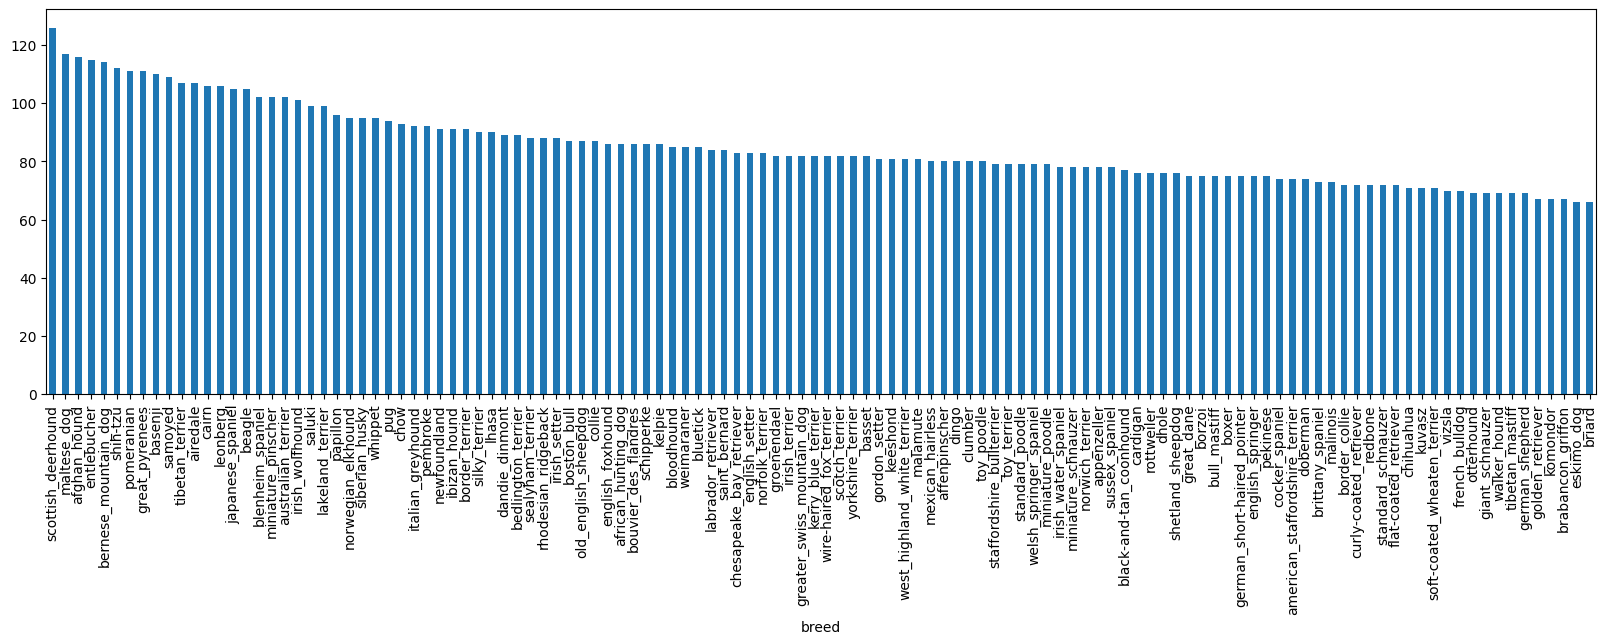

In [ ]:
# How many images of each breed are there?
print(labels_csv["breed"].value_counts())
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 5))
labels_csv["breed"].value_counts().median()

### Load Images

In [ ]:
# Create pathnames for image IDs
filenames = [LIST_DIR_PATH + "data/train/" + fname + ".jpg" for fname in labels_csv.id]

In [ ]:
train_folder_list = os.listdir(LIST_DIR_PATH + "data/train")
# Check the number of images in train folder
len(train_folder_list)

KeyboardInterrupt: 

In [ ]:
test_folder_list = os.listdir(LIST_DIR_PATH + "data/test")
# Check the number of images in test folder
len(test_folder_list)

10208

In [ ]:
# Check whether number of filenames match with number of actual images in train folder
print("Filenames match and dataset is ready") if len(os.listdir(LIST_DIR_PATH + "data/train")) == len(filenames) else print("!!! CAUTION: Filenames do not match !!!")

!!! CAUTION: Filenames do not match !!!


Breed is chesapeake_bay_retriever


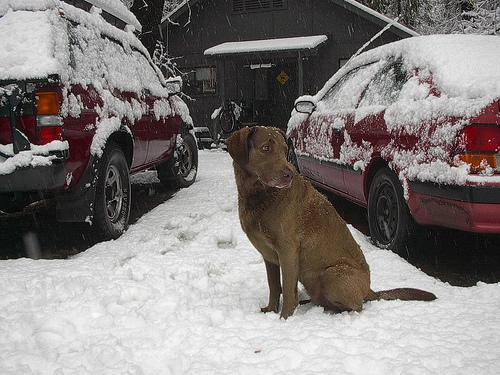

In [ ]:
# display an item as image and its breed to confirm filenames
i = 10221 # i < len(labels_csv), i.e. 10222

print(f"Breed is {labels_csv.breed[i]}")
Image(filename=filenames[i])

### Prepare data - convert labels to numerical arrays

In [ ]:
# create a numpy array for labels
labels = labels_csv.breed.to_numpy() # same as labels = np.array(labels_csv["breed"])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
# check if num of labels == num of filenames
if len(labels) == len(filenames):
  print("Number of labels matches the number of filenames.")
else:
  print("Number of labels does not match the number of filenames! Check data directories")

Number of labels matches the number of filenames.


In [ ]:
# extract unique breed names into an array
unique_breeds = np.unique(labels)
len(unique_breeds), unique_breeds[19]

(120, 'boston_bull')

In [ ]:
# convert labels into boolean arrays against the unique breeds
# labels[0] == unique_breeds # returns an array of booleans and of length = len(unique_breeds), with index of the original label being true
boolean_labels = [label == unique_breeds for label in labels]
len(boolean_labels), boolean_labels[0]

(10222,
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]))

In [ ]:
numeric_labels = [bool_lbl.astype(int) for bool_lbl in boolean_labels]
len(numeric_labels), numeric_labels[0]

(10222,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
# DEMO how to convert the boolean arrays into numeric
i = 0
print(labels[i]) # returns given string label
print(np.where(unique_breeds == labels[i])) # returns array with index in unique breed that has the given label
print(boolean_labels[i].argmax()) # returns the index of boolean label where true occurs
print(boolean_labels[i].astype(int)) # cast the given boolean array into 0s and 1s

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Creating training / validation set with 1000 images

In [ ]:
# Create X and y
X = filenames
y = numeric_labels
# y = boolean_labels

In [ ]:
# Split data using just 1000 sample images
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_SAMPLE_IMAGES],
                                                  y[:NUM_SAMPLE_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
X_train[:5], X_val[:5], y_train[:1], y_val[:1]

(['/content/drive/MyDrive/Colab Notebooks/K9-007/data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/Colab Notebooks/K9-007/data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/drive/MyDrive/Colab Notebooks/K9-007/data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/content/drive/MyDrive/Colab Notebooks/K9-007/data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/content/drive/MyDrive/Colab Notebooks/K9-007/data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 ['/content/drive/MyDrive/Colab Notebooks/K9-007/data/train/0ca9280205bd68d201e1d708db3f209d.jpg',
  '/content/drive/MyDrive/Colab Notebooks/K9-007/data/train/12405b2e93417d81f5308769c4e184c7.jpg',
  '/content/drive/MyDrive/Colab Notebooks/K9-007/data/train/1242da788ce85d4311e1cc9922a0a809.jpg',
  '/content/drive/MyDrive/Colab Notebooks/K9-007/data/train/1015e4eba660def32e7e52b89fe3a9c6.jpg',
  '/content/drive/MyDrive/Colab Notebooks/K9-007/data/train/09d5ac8026b8a7f7d1acae244765fe24.jpg'],
 [array(

## Preprocessing images (converting to Tensors)

We'll write a function to Process Image:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable `image`
3. Turn the image into Tensors
4. Normalize the image (convert colour channel from 0-255 to 0-1)
4. Resize the image to (224, 224)
5. Return the modifies `image`

We'll use the process image and return in another function to combine the processed image and label as a tuple.

In [ ]:
def process_image(image_path, image_size=IMG_SIZE):
  """
  Accepts the file path of an image and the optional image size (defaults to the image size defined globally)
  Returns the processed image as a Tensor in the given size
  """
  # Read the file path an store in image variable
  image = tf.io.read_file(image_path)
  # Convert jpeg image to Tensors and normalize to 3 color channels
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to given image size
  image = tf.image.resize(image, size=(image_size, image_size))

  return image

In [ ]:
def get_image_label(image_path, label):
  """
  Accepts the image file path and associated label,
  processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return (image, label)

In [ ]:
# DEMO: How the image has been turned to tensors using the above 2 functions
get_image_label(X[42], y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

## Turning data into batches

In [ ]:
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Returns data batches created out of processed image and label pairs.
  Accepts image data (X) and label data(y) is optional so that we may create batches of test data without labels
  Also accepts optional batch size which defaults to globally defined constant
  Test, Validation and Training data are "batched" differently so provide valid_data or test_data booleans if needed
  """
  # Create dataset from tensor slices using given X (and y) and batch the processed image maps

  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(batch_size)
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(get_image_label).batch(batch_size)
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffle training data before processing and batching
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_image_label).batch(batch_size)

  return data_batch

In [ ]:
# Create batches of training and validation sets
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Checkout and confirm the data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int32, name=None)))

## Visualising data batches

In [ ]:
def display_images(images, labels, num_rows, num_cols):
  """
  Plots a given images into specified rows and columns
  """
  plt.figure(figsize=(10,10))
  for i in range(num_rows * num_cols):
    ax = plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis('off')

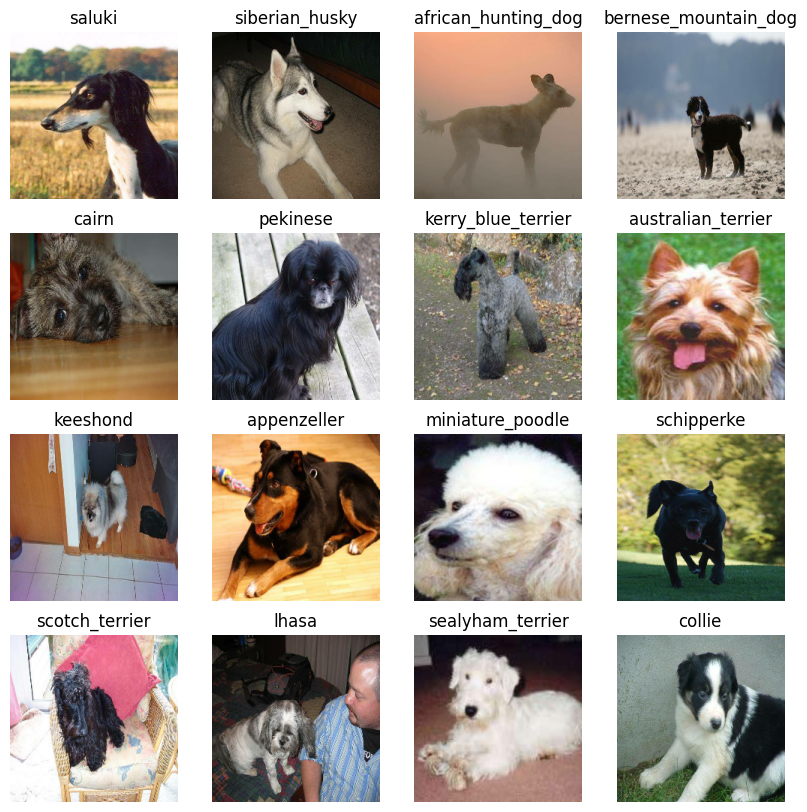

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
display_images(train_images, train_labels, 4, 4)

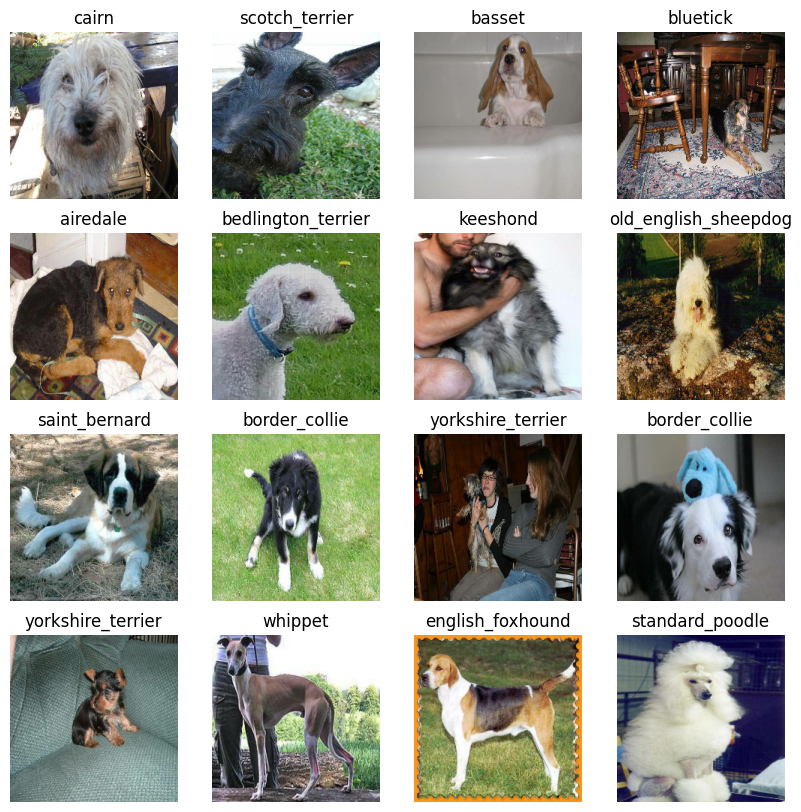

In [ ]:
valid_images, valid_labels = next(valid_data.as_numpy_iterator())
display_images(valid_images, valid_labels, 4, 4)

## Building a Baseline model with Transfer Learning

We will build a Sequential model with pretrtained model, Google's MobileNet V2 as image feature extractor.

https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1


### Model Setup

#### Inputs
A three-channel image of variable size - the model does NOT support batching.
 The input tensor is a tf.float32 tensor with shape [1, height, width, 3] with values in [0.0, 1.0].

#### Outputs
The output dictionary contains:

detection_boxes: a tf.float32 tensor of shape [N, 4] containing bounding box coordinates in the following order: [ymin, xmin, ymax, xmax].  
detection_class_entities: a tf.string tensor of shape [N] containing detection class names as Freebase MIDs.  
detection_class_names: a tf.string tensor of shape [N] containing human-readable detection class names.  
detection_class_labels: a tf.int64 tensor of shape [N] with class indices.  
detection_scores: a tf.float32 tensor of shape [N] containing detection scores.  

In [ ]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

OUTPUT_SHAPE = len(unique_breeds)

MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1"

### Create Baseline Model function

In [ ]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print(f"Building baseline model (transfer learning) using {model_url}")
  model = tf.keras.Sequential([
    hub.KerasLayer(model_url),
    tf.keras.layers.Dense(units=output_shape,
                            activation='softmax')
  ])
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )
  model.build(input_shape)
  return model

### Creating the model

In [ ]:
model = create_model()
model.summary()

Building baseline model (transfer learning) using https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


### Creating Callbacks

##### Create Tensorboard callback to track model progress

In [ ]:
# TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Build TensorBoard callback
def create_tensorboard_callback():
  # Create log directory for storing TensorBoard logs
  logdir = os.path.join(LIST_DIR_PATH + "logs",
                        # logs should get tracked whenever an experiment is run
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

##### Create Early Stopping Callback

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training data in batches

Training a model on subset of data (say 1000 images, this will be decided by `NUM_EPOCHS` constant)


In [ ]:
# Function to train the model
def train_model(model):
  """
  Accepts a model and returns a trained model.
  """
  tensorboard = create_tensorboard_callback()
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  return model

In [ ]:
model = train_model(model)

Epoch 1/100
25/25 [==============================] - 344s 14s/step - loss: 4.6465 - accuracy: 0.0875 - val_loss: 3.7045 - val_accuracy: 0.2200
Epoch 2/100
25/25 [==============================] - 6s 226ms/step - loss: 1.6580 - accuracy: 0.6988 - val_loss: 2.3413 - val_accuracy: 0.4750
Epoch 3/100
25/25 [==============================] - 4s 151ms/step - loss: 0.5801 - accuracy: 0.9337 - val_loss: 1.8343 - val_accuracy: 0.5900
Epoch 4/100
25/25 [==============================] - 5s 193ms/step - loss: 0.2610 - accuracy: 0.9875 - val_loss: 1.6295 - val_accuracy: 0.6350
Epoch 5/100
25/25 [==============================] - 4s 161ms/step - loss: 0.1491 - accuracy: 0.9950 - val_loss: 1.5397 - val_accuracy: 0.6700
Epoch 6/100
25/25 [==============================] - 5s 184ms/step - loss: 0.1026 - accuracy: 0.9987 - val_loss: 1.4771 - val_accuracy: 0.6700
Epoch 7/100
25/25 [==============================] - 5s 184ms/step - loss: 0.0762 - accuracy: 1.0000 - val_loss: 1.4436 - val_accuracy: 0.6750

#### Visualizing logs in TensorBoard

In [ ]:
# Access logs directory and visualize contents
%tensorboard --logdir f"{LIST_DIR_PATH}logs"

## Evaluation and Predictions using the trained model

##### Predict validation data

In [ ]:
predictions = model.predict(valid_data, verbose=1)

7/7 [==============================] - 2s 165ms/step


In [ ]:
predictions.shape

(200, 120)

In [ ]:
# Demo of prediction using a single item
index = 33 # Less than 200, our validation data size (out of 1000 images in training set)
print(predictions.size) # Rows (200)* Cols (120) of prediction - the probability of the image to be in each class
print(f"Sum: {np.sum(predictions[index])}") # sum of probabilities of all possibilities add up to 1
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}") # index of max value
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

24000
Sum: 0.9999998807907104
Max value (probability of prediction): 0.2669260799884796
Max index: 72
Predicted label: malinois


#### Get Prediction Probability

In [ ]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [ ]:
# Demo: get label
get_pred_label(predictions[33])

'malinois'

### Unbatch the validation data
Since validation data is in batches, we need to unbatch it in order to make sense of the predictions and compare prediction to validation labels

In [ ]:
def unbatch_dataset(data):
  """
  Accepts a batch data set and unbatch it. Returns a list of images and labels
  """
  images = []
  labels = []

  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

In [ ]:
val_images, val_labels = unbatch_dataset(valid_data)
get_pred_label(val_labels[33])

'affenpinscher'

## Visualising

#### Visualizing top prediction

In [ ]:
def plot_pred(prediction, truth_label, image):
  """
  Accepts the prediction probability, truth label (for validating the prediction), the image to display
  Converts prediction into a label and plots the prediction against the truth along with the image validated
  """
  pred_label = get_pred_label(prediction)

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  color = "green" if pred_label == truth_label else "red"
  plt.title("Prediction: {}, Probability: {:2.0f}% \n Actual: {}".format(pred_label,
                                                                         np.max(prediction)*100,
                                                                         truth_label),
            color=color)

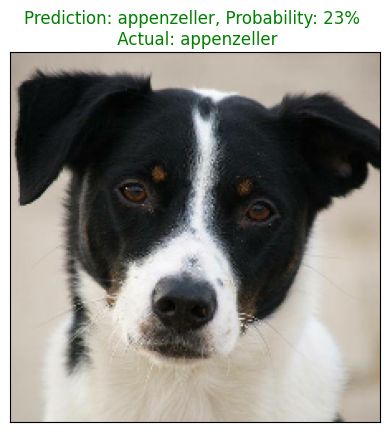

In [ ]:
i = 199
plot_pred(prediction=predictions[i],
          truth_label=val_labels[i],
          image=val_images[i])

### Visualizing top `n` predictions for each image

In [ ]:
def plot_pred_conf(prediction, truth_label, n=10):
  """
  Accept prediction probability array and truth label
  Plots the top 'n' predictions for the image
  """
  # Find top n prediction confidence indices
  top_n_pred_indices = prediction.argsort()[-n:][::-1]

  # Find top n prediction confidence values
  top_n_pred_values = prediction[top_n_pred_indices]

  # Find top n prediction labels
  top_n_pred_labels = unique_breeds[top_n_pred_indices]

  # Setup the plot
  top_plot = plt.bar(np.arange(len(top_n_pred_labels)),
                     top_n_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_n_pred_labels)),
                     labels=top_n_pred_labels,
                     rotation='vertical')

  # Change color of the label if it is the truth label
  if np.isin(truth_label, top_n_pred_labels):
    top_plot[np.argmax(top_n_pred_labels == truth_label)].set_color("green")
  else:
    pass

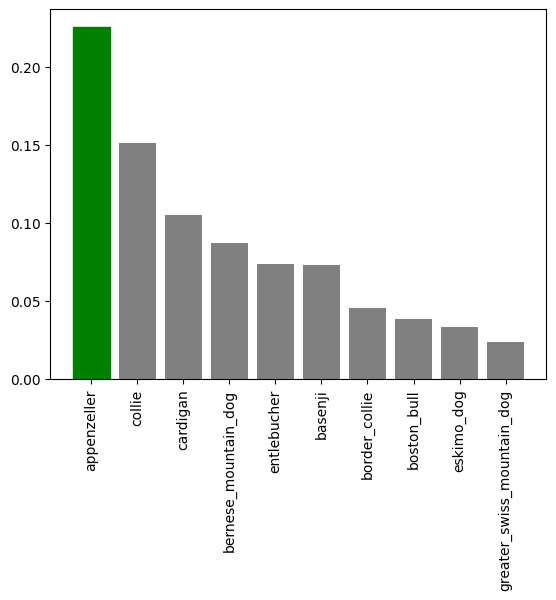

In [ ]:
i = 199
plot_pred_conf(prediction=predictions[i],
               truth_label=val_labels[i])

In [ ]:
#### Visualizing multiple images

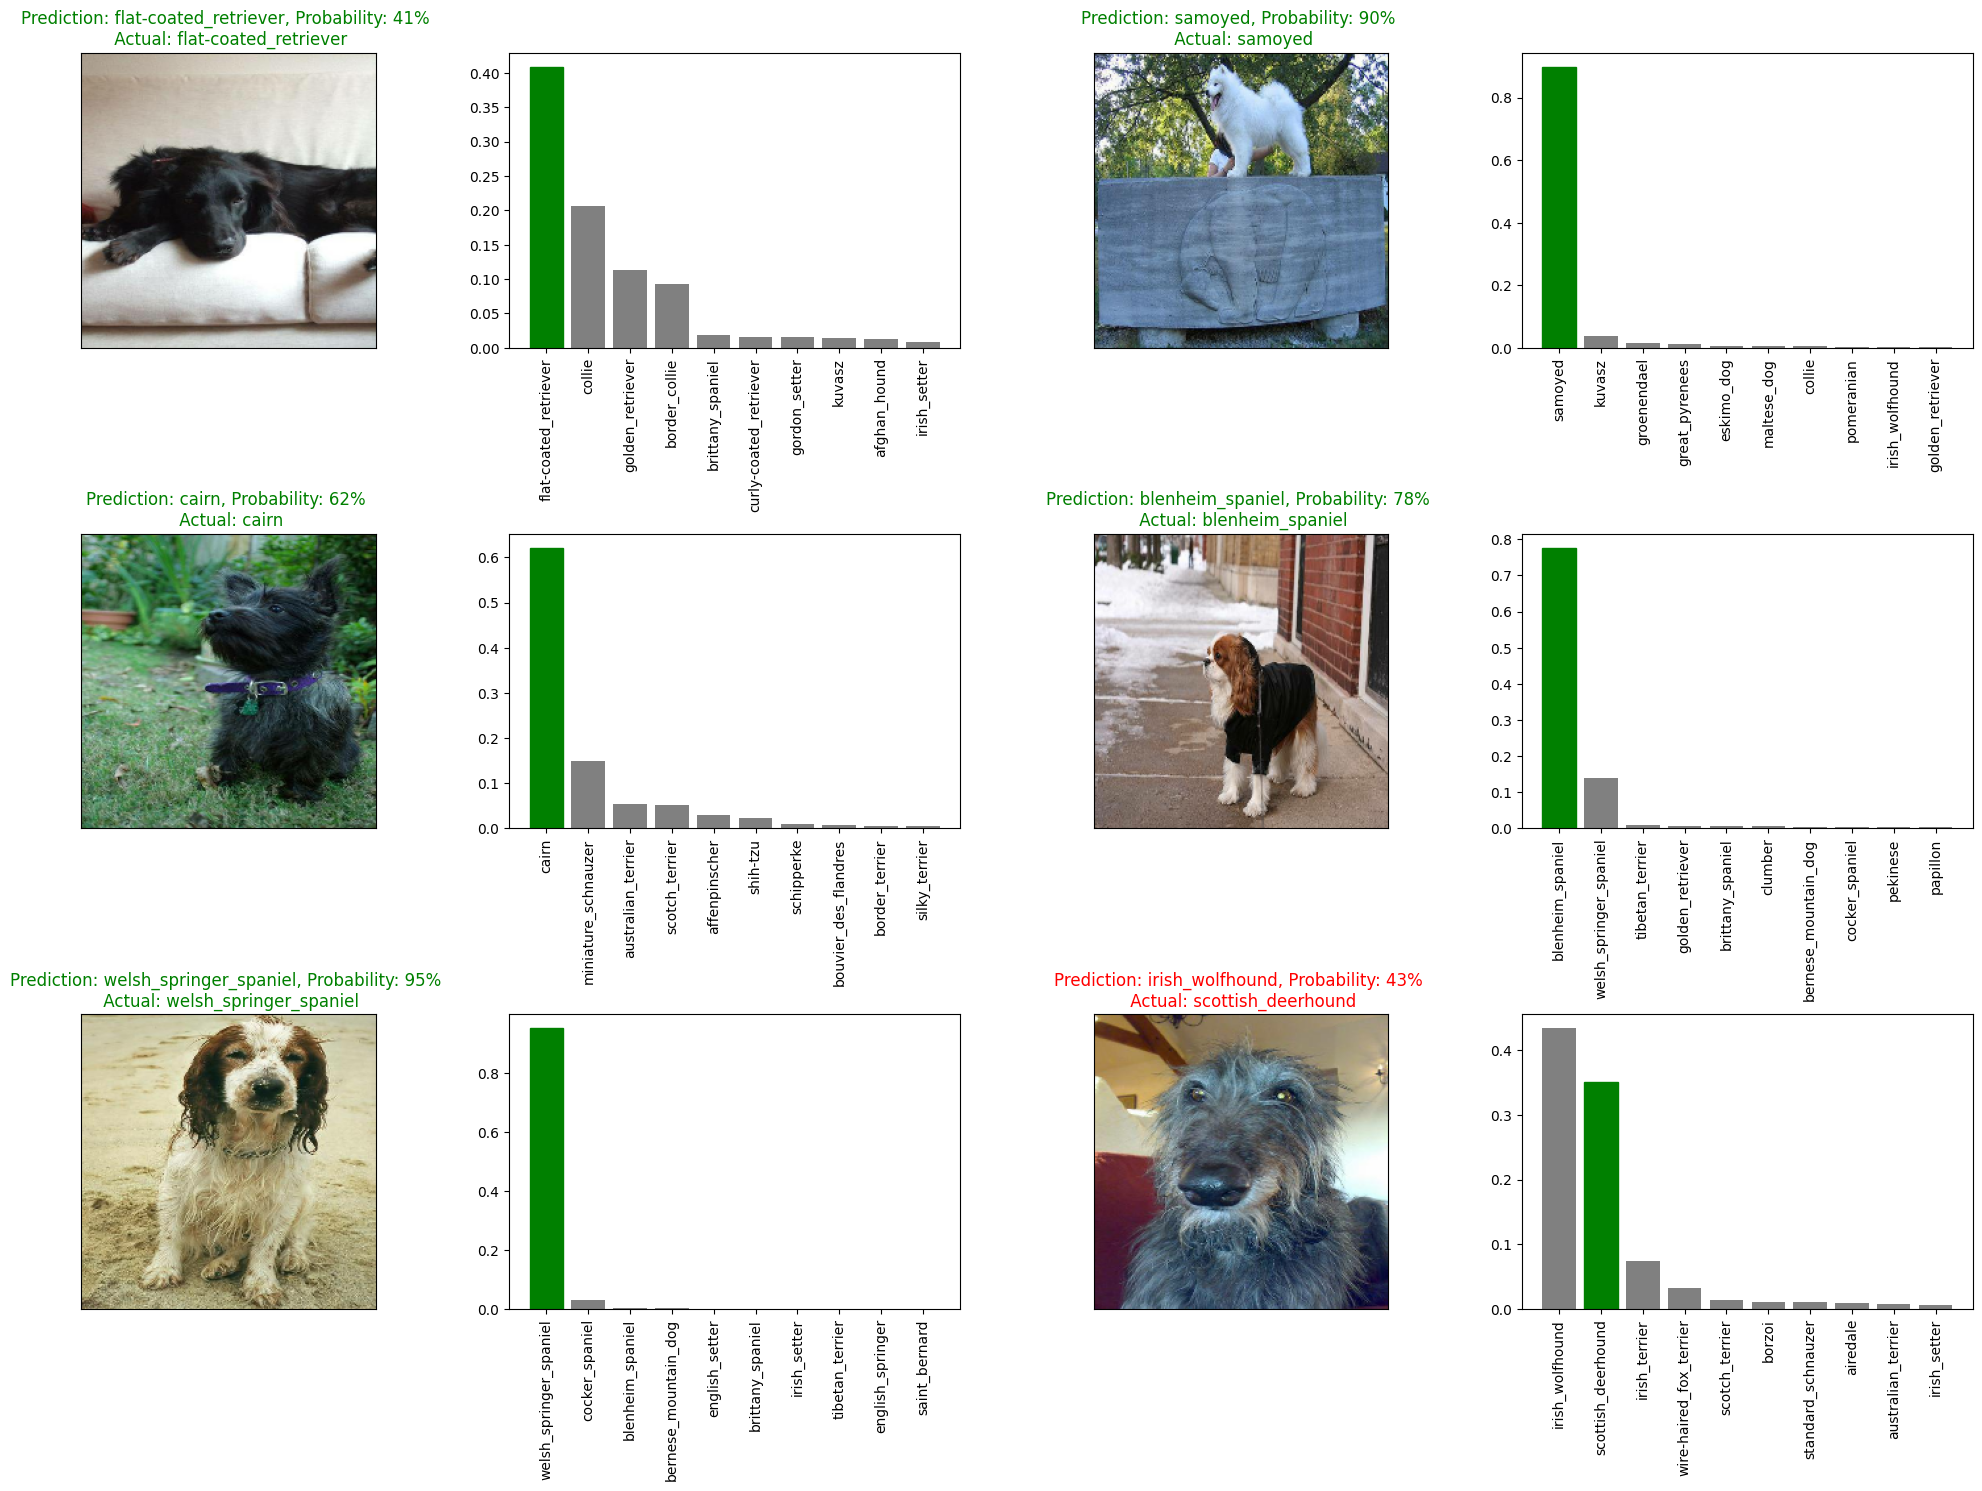

In [ ]:
i_multiplier = 20

num_rows = 3
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):

  index = i + i_multiplier

  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction=predictions[index],
            truth_label=val_labels[index],
            image=val_images[index])

  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction=predictions[index],
            truth_label=val_labels[index])

plt.tight_layout(h_pad=1.0)

## Save a trained model

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a model in models directory and appends given suffix
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join(LIST_DIR_PATH+"models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "_" + suffix + ".h5"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

#### Save the 1000 image trained model in the models directory

In [ ]:
save_model(model, suffix="1000-images-mobilnetv2-Adam")

Saving model to: /content/drive/MyDrive/Shortcuts/K9-007/models/20240725-12521721911934_1000-images-mobilnetv2-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/Shortcuts/K9-007/models/20240725-12521721911934_1000-images-mobilnetv2-Adam.h5'

## Demo Loading a trained model

In [ ]:
def load_model(model_path):
  """
  Loads a model from given path
  """
  print(f"Loading saved model from {model_path}...")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer": hub.KerasLayer})
  return model

In [ ]:
loaded_1000_image_model = load_model(LIST_DIR_PATH + "models/20240725-12521721911934_1000-images-mobilnetv2-Adam.h5")

Loading saved model from /content/drive/MyDrive/Shortcuts/K9-007/models/20240725-12521721911934_1000-images-mobilnetv2-Adam.h5...


##### Evaluate the old model AND the loaded model for testing

In [ ]:
model.evaluate(valid_data)

7/7 [==============================] - 1s 183ms/step - loss: 1.3501 - accuracy: 0.6850


[1.3500545024871826, 0.6850000023841858]

In [ ]:
loaded_1000_image_model.evaluate(valid_data)

7/7 [==============================] - 4s 98ms/step - loss: 1.3501 - accuracy: 0.6850


[1.3500545024871826, 0.6850000023841858]

## Training the bigger model with full data

In [ ]:
len(X), len(y)

(10222, 10222)

#### Create data batches

In [ ]:
full_data = create_data_batches(X, y)

Creating training data batches...


#### Create model with for full data training

In [ ]:
full_model = create_model()

#### Setup full model callbacks

In [ ]:
full_model_tensorboard = create_tensorboard_callback()
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                             patience=3)

#### Fitting the full model with full data

In [ ]:
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 3166s 10s/step - loss: 1.3590 - accuracy: 0.6624
Epoch 2/100
320/320 [==============================] - 45s 139ms/step - loss: 0.4016 - accuracy: 0.8796
Epoch 3/100
320/320 [==============================] - 46s 143ms/step - loss: 0.2407 - accuracy: 0.9313
Epoch 4/100
320/320 [==============================] - 44s 139ms/step - loss: 0.1530 - accuracy: 0.9630
Epoch 5/100
320/320 [==============================] - 44s 137ms/step - loss: 0.1063 - accuracy: 0.9773
Epoch 6/100
320/320 [==============================] - 44s 137ms/step - loss: 0.0775 - accuracy: 0.9870
Epoch 7/100
320/320 [==============================] - 44s 136ms/step - loss: 0.0589 - accuracy: 0.9902
Epoch 8/100
320/320 [==============================] - 43s 134ms/step - loss: 0.0469 - accuracy: 0.9941
Epoch 9/100
320/320 [==============================] - 45s 140ms/step - loss: 0.0381 - accuracy: 0.9967
Epoch 10/100
320/320 [==============================] - 45s 139m

#### Saving the full model

In [ ]:
save_model(full_model, suffix="full-image-set-mobilnetv2-Adam")

Saving model to: /content/drive/MyDrive/Shortcuts/K9-007/models/20240725-14241721917472_full-image-set-mobilnetv2-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/Shortcuts/K9-007/models/20240725-14241721917472_full-image-set-mobilnetv2-Adam.h5'

#### Load the saved model

In [ ]:
loaded_full_model = load_model(LIST_DIR_PATH+"models/20240725-14241721917472_full-image-set-mobilnetv2-Adam.h5")

Loading saved model from /content/drive/MyDrive/Colab Notebooks/K9-007/models/20240725-14241721917472_full-image-set-mobilnetv2-Adam.h5...


## Making Predictions on the test set with full model

In [ ]:
len(test_folder_list)

10208

In [ ]:
test_filenames = [LIST_DIR_PATH + "data/test/" + fname for fname in test_folder_list]

In [ ]:
test_filenames[:5]

['/content/drive/MyDrive/Colab Notebooks/K9-007/data/test/2dd85ee4d1315a12aea5cb1b2ffa4fe6.jpg',
 '/content/drive/MyDrive/Colab Notebooks/K9-007/data/test/97a0a4b27e8f12596482e4f6487786cb.jpg',
 '/content/drive/MyDrive/Colab Notebooks/K9-007/data/test/5c48a8729509239de0920449aa44649a.jpg',
 '/content/drive/MyDrive/Colab Notebooks/K9-007/data/test/aa3b9907adc147f93a453a3a3fb68c34.jpg',
 '/content/drive/MyDrive/Colab Notebooks/K9-007/data/test/9eea61fd6a1df05ec18e53edaa54b66d.jpg']

In [ ]:
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [ ]:
test_predictions = loaded_full_model.predict(test_data, verbose=1)

319/319 [==============================] - 3452s 11s/step


##### Save test predictions

In [ ]:
test_predictions

NameError: name 'test_predictions' is not defined

In [ ]:
np.savetxt(LIST_DIR_PATH + "preds_array" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".csv",
           test_predictions,
           delimiter=",")

##### Demo: Load saved predictions

In [ ]:
pred_file_to_load = LIST_DIR_PATH + "preds_array.csv"
loaded_test_predictions = np.loadtxt(pred_file_to_load,
                                     delimiter=",")

In [ ]:
pred_file_to_load

'/content/drive/MyDrive/Colab Notebooks/K9-007/preds_array.csv'

## Preparing test predictions for Kaggle

In [ ]:
# Create an empty DataFrame with each breed as a column and filenames as id
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [ ]:
# Populate ID column with test image IDs
# test_ids = [os.path.splitext(path)[0] for path in test_folder_list]
test_ids = [os.path.splitext(path)[0] for path in os.listdir(LIST_DIR_PATH + "data/test")]
preds_df["id"] = test_ids
preds_df.head()

id affenpinscher afghan_hound  \
0  e726ac27864ecbde1f5822c4d6e26c17           NaN          NaN   
1  e7ed96b272013c6de9505a753816ce75           NaN          NaN   
2  e4897fe96990006c10ec7336772cbd37           NaN          NaN   
3  dd026c42cfd91ea64b1fe5db04a18863           NaN          NaN   
4  e381c5fcf1420985b20117e4bc7d38cd           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [ ]:
# Populate the breed columns with predictions
preds_df[list(unique_breeds)] = loaded_test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  e726ac27864ecbde1f5822c4d6e26c17   1.367957e-10  3.402653e-06   
1  e7ed96b272013c6de9505a753816ce75   1.179557e-07  4.493622e-09   
2  e4897fe96990006c10ec7336772cbd37   8.594256e-12  1.072634e-08   
3  dd026c42cfd91ea64b1fe5db04a18863   6.858606e-12  1.290312e-08   
4  e381c5fcf1420985b20117e4bc7d38cd   2.806477e-11  6.311246e-05   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         2.822760e-08  6.588887e-05                    5.822060e-06   
1         2.926364e-10  5.682704e-07                    2.889113e-07   
2         9.102440e-10  8.996414e-17                    9.309633e-13   
3         6.583917e-08  1.141945e-07                    7.016051e-14   
4         2.901691e-10  3.171248e-09                    2.067660e-09   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  2.596107e-06        6.267591e-10  9.010355e-09  1.871055e-08  ...   
1  8.347570e-11        9.917232e-01  1.912000e-07  9.077925e-08  ...   
2  2.158453e-12        4.146526e-09  1.077516e-10  8.530303e-12  ...   
3  1.053767e-09        4.528472e-09  2.416616e-11  1.795655e-10  ...   
4  3.976209e-06        3.632586e-11  6.328851e-07  2.629012e-07  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  4.954578e-09  2.273604e-12  2.687198e-06  1.372505e-06  7.422914e-05   
1  2.607487e-07  1.387267e-06  1.127478e-07  6.653264e-09  9.495010e-10   
2  2.334262e-13  6.399425e-09  1.091471e-12  1.001209e-09  1.962253e-11   
3  2.162704e-13  2.807911e-10  5.826388e-12  4.484472e-09  3.140192e-10   
4  1.018132e-08  2.795692e-10  4.327597e-04  2.725740e-07  2.095760e-07   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            4.459789e-11                 2.069688e-10  4.486309e-04   
1            2.162254e-08                 7.984149e-08  6.239714e-10   
2            2.342610e-14                 2.886666e-08  6.559573e-07   
3            3.862544e-11                 7.853961e-11  7.472392e-11   
4            7.370780e-05                 7.597430e-11  5.353982e-05   

   wire-haired_fox_terrier  yorkshire_terrier  
0             2.023139e-08       9.472536e-09  
1             2.223450e-07       4.125960e-03  
2             2.044215e-11       1.481076e-08  
3             1.275688e-08       4.769366e-12  
4             1.295299e-07       6.154463e-08  

[5 rows x 121 columns]

In [ ]:
# Save the data frame to csv for Kaggle submission
preds_df.to_csv(LIST_DIR_PATH + "full_model_predictions_submissions_2a_mobilenetv2.csv", index=False)

## Making predictions on custom images for demo

In [ ]:
custom_path = LIST_DIR_PATH + "custom_images/dog_images/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths

['/content/drive/MyDrive/Colab Notebooks/K9-007/custom_images/dog_images/IMG_2889.jpg',
 '/content/drive/MyDrive/Colab Notebooks/K9-007/custom_images/dog_images/4.jpg',
 '/content/drive/MyDrive/Colab Notebooks/K9-007/custom_images/dog_images/2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/K9-007/custom_images/dog_images/Screenshot 2024-07-19 at 6.32.38\u202fPM.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/K9-007/custom_images/dog_images/Screenshot 2024-07-19 at 6.29.13\u202fPM.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/K9-007/custom_images/dog_images/5.jpg',
 '/content/drive/MyDrive/Colab Notebooks/K9-007/custom_images/dog_images/IMG_5252.JPG',
 '/content/drive/MyDrive/Colab Notebooks/K9-007/custom_images/dog_images/3.jpg',
 '/content/drive/MyDrive/Colab Notebooks/K9-007/custom_images/dog_images/6.jpg']

In [ ]:
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [ ]:
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 5s 5s/step


#### Visualising predictions on custom images

In [ ]:
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]

In [ ]:
custom_images = []

for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

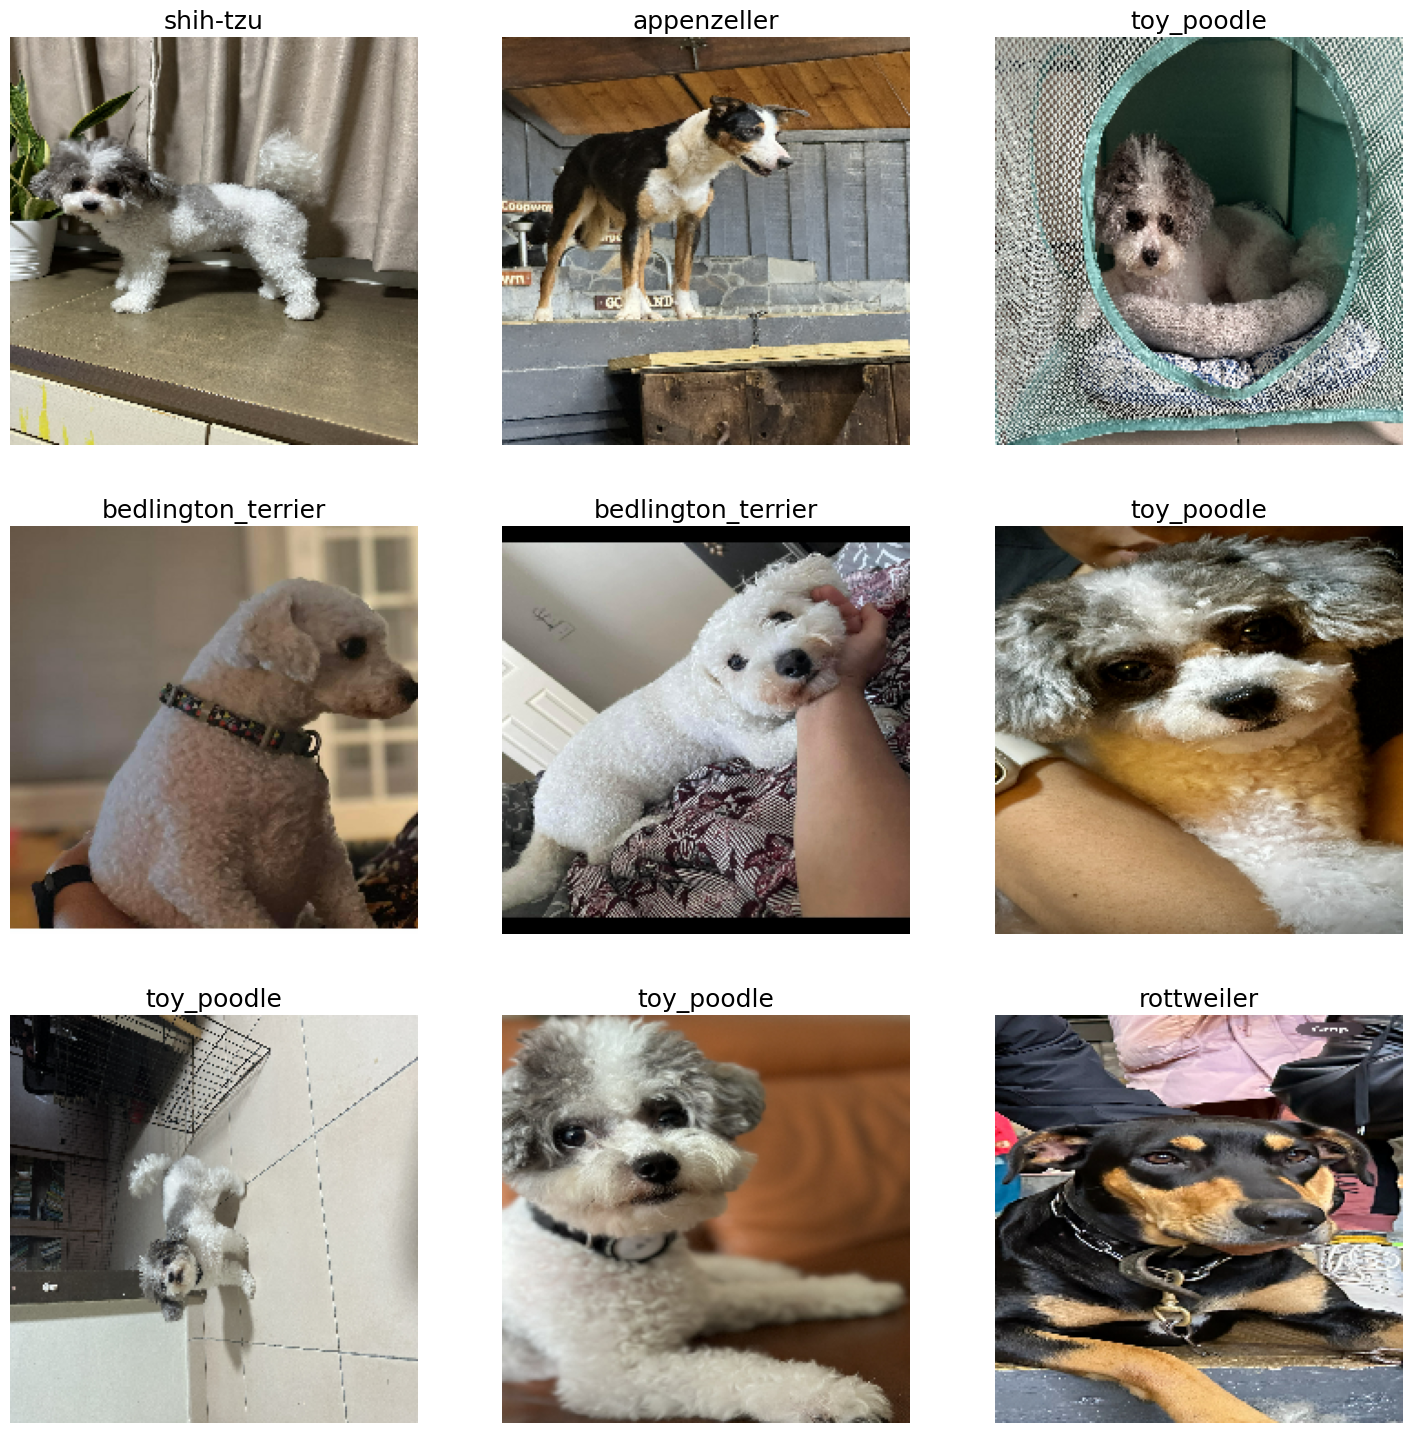

In [ ]:
plt.figure(figsize=(2*len(custom_images),2*(len(custom_images))))
for i, image in enumerate(custom_images):
  plt.subplot(3, 3, i+1)
  plt.axis('off')
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i], fontsize=18)
  plt.imshow(image)